# NTU Global Research Programme - Human Emotion Analysis

## Microsaccade Detection and Analysis

This notebook provides sample code for detecting and analyzing microsaccades in a dataset consisting of the gaze positions of both eyes and timestamps. The code is based on Engbert R (2006) algorithms, with reference to the Microsaccade Toolbox in R.

The dataset is a public dataset.

In [1]:
# Import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import *

In [2]:
# Import data (single trial)
d = pd.read_csv('eye_data.dat', sep = '\t', header = None,
                names = ['Timestamp','Leftx','Lefty','Rightx', 'Righty'])
d.head()

,Timestamp,Leftx,Lefty,Rightx,Righty
0,0.0,0.06732,-0.22176,-0.25740,-0.86724
1,2.0,0.07524,-0.20196,-0.26136,-0.87120
2,4.0,0.08316,-0.20592,-0.25740,-0.86724
3,6.0,0.08316,-0.20988,-0.25740,-0.88704
4,8.0,0.07524,-0.20592,-0.25740,-0.85536


In [3]:
# Select epoch from trial, transform to dataframe
idx = list(np.arange(3000,4500))
xl = np.asmatrix(d.iloc[idx,[1,2]])
xr = np.asmatrix(d.iloc[idx,[3,4]])

In [4]:
import sys

def vecvel(x, SAMPLING=1000, TYPE=2):
    """
    Compute velocities
    """
    d = x.shape
    N = d[0]
    v = np.matrix(np.array([0]*N*2).reshape(N,2), dtype = float)
    
    if TYPE == 2:
        v[2:(N-2),] = (SAMPLING/6)*(x[4:N,] + x[3:(N-1),] - x[1:(N-3),] - x[0:(N-4),])
        v[1,] = (SAMPLING/2)*(x[2,] - x[0,])
        v[(N-2),] = (SAMPLING/2)*(x[N-1,] - x[(N-3),])  
    else:
        v[1:(N-1),] = (SAMPLING/2)*(x[2:N,] - x[0:(N-2),])
    return v

def smoothdata(x, TYPE = 2):
    d = x.shape
    N = d[0]
    x0 = x[0,] # 1st row
    v = vecvel(x, SAMPLING=1, TYPE=TYPE)
    v[0,] = v[0,] + x0
    xs = np.matrix(np.array([np.cumsum(v[:,0]),np.cumsum(v[:,1])]), dtype = float).transpose()
    return xs

def microsacc(x, VFAC = 6, MINDUR = 6, SAMPLING = 1000):
    v = vecvel(x, SAMPLING=SAMPLING)
    
    # Compute threshold
    medx = np.median(np.array(v[:,0])) # Col 1
    msdx = np.sqrt(np.median(np.array(np.square(v[:,0] - medx))))
    medy = np.median(np.array(v[:,1])) # Col 2
    msdy = np.sqrt(np.median(np.array(np.square(v[:,1] - medy))))

    if msdx < 1e-10:
        msdx = np.sqrt(np.mean(np.array(np.square(v[:,0]))) - np.square(np.mean(np.array(v[:,0]))))
    if msdx < 1e-10:
        sys.exit("msdx < realmin")

    if msdy < 1e-10:
        msdy = np.sqrt(np.mean(np.array(np.square(v[:,1]))) - np.square(np.mean(np.array(v[:,1]))))
    if msdy < 1e-10:
        sys.exit("msdy < realmin")

    radiusx = VFAC*msdx
    radiusy = VFAC*msdy
    radius = np.array([radiusx,radiusy])

    # Apply test criterion: elliptic treshold
    test = np.square(v[:,0]/radiusx) + np.square(v[:,1]/radiusy)
    indx = []
    for index, item in enumerate(np.squeeze(np.asarray(test))):
        if item > 1:
            indx.append(index)

    # Determine saccades
    N = len(indx) 
    nsac = 0
    sac = []
    dur = 1
    a = 1
    k = 0

    # Loop over saccade candidates
    while k < N-1:
        if indx[k+1] - indx[k] == 1:
            dur = dur + 1
        else:
            # Minimum duration criterion (exception: last saccade)
            if dur >= MINDUR:
                nsac = nsac + 1
                b = k
                sac.append([indx[a],indx[b],0,0,0,0,0])
            a = k + 1
            dur = 1
        k = k + 1

    # Check minimum duration for last microsaccade
    if  dur >= MINDUR:
        nsac = nsac + 1
        b = k
        sac.append([indx[a],indx[b],0,0,0,0,0])

    if nsac > 0: 
        # Compute peak velocity, horiztonal and vertical components
        for s in range(nsac):
            # Onset and offset for saccades
            a = sac[s][0] 
            b = sac[s][1]
            idx = np.arange(a,b+1)
            # Saccade peak velocity (vpeak)
            vpeak = max(np.sqrt(np.square(v[idx,0]) + np.square(v[idx,1])))
            sac[s][2] = vpeak[0,0]
            # Saccade vector (dx,dy)
            dx = x[b,0]-x[a,0] 
            dy = x[b,1]-x[a,1] 
            sac[s][3:5] = [dx,dy]
            # Saccade amplitude (dX,dY)
            minx = min(x[idx,0])
            maxx = max(x[idx,0])
            miny = min(x[idx,1])
            maxy = max(x[idx,1])
            ix1 = [j[0,0] for j in x[idx,0]].index(min(x[idx,0]))
            ix2 = [j[0,0] for j in x[idx,0]].index(max(x[idx,0]))
            iy1 = [j[0,0] for j in x[idx,1]].index(min(x[idx,1]))
            iy2 = [j[0,0] for j in x[idx,1]].index(max(x[idx,1]))
            dX = np.sign(ix2-ix1)*(maxx-minx)
            dY = np.sign(iy2-iy1)*(maxy-miny)
            #print('ix2-ix1 = {} - {} = {}'.format(ix2,ix1,ix2-ix1))
            #dX = ((ix2-ix1)/abs(ix2-ix1))*(maxx-minx)
            #print('iy2-iy1 = {} - {} = {}'.format(iy2,iy1,iy2-iy1))
            #dY = ((iy2-iy1)/abs(iy2-iy1))*(maxy-miny)
            sac[s][5:7] = [dX[0,0],dY[0,0]]
        sac = [sac, radius]
    else:
        sac = []
    
    return sac
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def simple_check(m, sac, index):
    list1 = []
    list2 = []
    # left  <- which( (m[i,1]<=sacl[,1]) & (sacl[,2]<=m[i,2]) )
    for i in range(len(sac)):
        if m[index][0] <= sac[i][0]:
            list1.append(i)
        if sac[i][1] <= m[index][1]:
            list2.append(i)
    list3 = intersection(list1, list2)
    return list3

def binsac(sacl,sacr):
    numr = len([i[0] for i in sacr[0]])
    numl = len([i[0] for i in sacl[0]])
    NB = 0
    NR = 0
    NL = 0

    if numr*numl > 0:
        # Determine saccade clusters
        TR = max([i[1] for i in sacr[0]])
        TL = max([i[1] for i in sacl[0]])
        TB = max([TL,TR])
        s = [0]*(TB + 2)

        for i in range(len(sacl[0])):
            left = np.arange(sacl[0][i][0],sacl[0][i][1]+1)
            for j in left:
                s[j] = 1

        for i in range(len(sacr[0])):
            right = np.arange(sacr[0][i][0],sacr[0][i][1]+1)
            for j in right:
                s[j] = 1

        s[0] = 0
        s[-1] = 0

        # Find onsets and offsets of microsaccades
        onoff = []
        for i in range(1, len(s)):
            if s[i] - s[i-1] != 0:
                onoff.append(i-1)
        m = [[onoff[i], onoff[i+1]] for i in range(0,len(onoff)-1,2)]
        N = len(m)

        # Determine binocular saccades
        Bin = []
        monol = []
        monor = []

        for i in range(N):
            listM = [[onoff[i], onoff[i+1]] for i in range(0,len(onoff)-1,2)]
            listSacL = [[[i[0] for i in sacl[0]][j],[i[1] for i in sacl[0]][j]] for j in range(len(sacl[0]))]
            listSacR = [[[i[0] for i in sacr[0]][j],[i[1] for i in sacr[0]][j]] for j in range(len(sacr[0]))]
            left = simple_check(listM, listSacL, i)
            right = simple_check(listM, listSacR, i)

            if len(left)*len(right) > 0:
                ampr = np.sqrt(np.square(np.matrix(np.array(sacr[0], dtype = float), dtype = float)[right,5])
                               + np.square(np.matrix(np.array(sacr[0], dtype = float), dtype = float)[right,6]))
                ampl = np.sqrt(np.square(np.matrix(np.array(sacl[0], dtype = float), dtype = float)[left,5])
                               + np.square(np.matrix(np.array(sacl[0], dtype = float), dtype = float)[left,6]))
                # Determine largest event in each eye
                ir = list(np.array(ampr)[0]).index(max(list(np.array(ampr)[0])))
                il = list(np.array(ampl)[0]).index(max(list(np.array(ampl)[0])))
                NB = NB + 1
                #Bin = rbind(bin,c(sacl[left[il],],sacr[right[ir],]))
                Bin.append([np.matrix(np.array(sacl[0], dtype = float), dtype = float)[left[il],:],
                            np.matrix(np.array(sacr[0], dtype = float), dtype = float)[right[ir],:]])
            else:
                # Determine monocular saccades
                if len(left) == 0:
                    NR = NR + 1
                    ampr = np.sqrt(np.square(np.matrix(np.array(sacr[0], dtype = float), dtype = float)[right,5])
                                   + np.square(np.matrix(np.array(sacr[0], dtype = float), dtype = float)[right,6]))
                    ir = list(np.array(ampr)[0]).index(max(list(np.array(ampr)[0])))
                    monor.append(np.matrix(np.array(sacr[0], dtype = float), dtype = float)[right[ir],:])
                if len(right) == 0:
                    NL = NL + 1
                    ampl = np.sqrt(np.square(np.matrix(np.array(sacl[0], dtype = float), dtype = float)[left,5])
                                   + np.square(np.matrix(np.array(sacl[0], dtype = float), dtype = float)[left,6]))
                    il = list(np.array(ampl)[0]).index(max(list(np.array(ampl)[0])))
                    monol.append(np.matrix(np.array(sacl[0], dtype = float), dtype = float)[left[il],:])
        else:
            # Special case of exclusively monocular saccades
            if numr == 0:
                Bin = None
                monor = None
                monol = sacl[0]
            if numl == 0:
                Bin = None
                monol = None
                monor = sacr[0]

    sac = [[NB,NL,NR],Bin,monol,monor]
    return sac

def rounddown(x):
    return int(np.floor(x / 100.0)) * 100

def plotMicroSac(sacl, sacr, xls, xrs, stimulusName, y = 1.05, figsize = (12,10), show = True):
    # (Binocular) microsaccades
    sac = binsac(sacl, sacr)
    N = sac[0][0]
    Bin = sac[1]
    
    fig, ax = plt.subplots(2,2, figsize = figsize, facecolor = 'white')
    plt.suptitle('Microsaccades\nStimulus: {}'.format(stimulusName), fontweight = 'bold', y = y)
    
    # Left eye
    # Plot trajectories
    ax[0,0].plot(xls[:,0], xls[:,1])
    temp = [list(np.array(sac[1])[i][0][0]) for i in range(len(np.array(sac[1])))]
    ax[0,0].plot(list(pd.DataFrame(xls).loc[[temp[i][1] for i in range(len(temp))],0]),
              list(pd.DataFrame(xls).loc[[temp[i][1] for i in range(len(temp))],1]), 'ro', alpha = 0.6)
    ax[0,0].set_title('Gaze Position (Left eye)', fontweight = 'bold')
    ax[0,0].set_xlabel('X position', fontweight = 'bold')
    ax[0,0].set_ylabel('Y position', fontweight = 'bold')

    # Plot velocities
    vls = vecvel(xls,SAMPLING)
    ax[0,1].plot(vls[:,0], vls[:,1])
    ax[0,1].set_title('Velocity (Left eye)', fontweight = 'bold')
    ax[0,1].set_xlabel('X velocity', fontweight = 'bold')
    ax[0,1].set_ylabel('Y velocity', fontweight = 'bold')

    for s in range(N):
        j = np.arange(Bin[s][0][0,0],Bin[s][0][0,1]+1)
        #lines(vls[j,1],vls[j,2],type='l',col='red',lwd=3)
        ax[0,1].plot(pd.DataFrame(vls).iloc[j,0], pd.DataFrame(vls).iloc[j,1], color = 'red')

    phi = np.arange(0, np.pi*2, np.pi*2/300)
    cx = sacl[1][0]*np.cos(phi)
    cy = sacl[1][1]*np.sin(phi)
    ax[0,1].plot(cx, cy, '--', color = 'green')

    # Right eye
    # Plot trajectories
    ax[1,0].plot(xrs[:,0], xrs[:,1])
    temp = [list(np.array(sac[1])[i][0][0]) for i in range(len(np.array(sac[1])))]
    ax[1,0].plot(list(pd.DataFrame(xrs).iloc[[temp[i][1] for i in range(len(temp))],0]),
              list(pd.DataFrame(xrs).iloc[[temp[i][1] for i in range(len(temp))],1]), 'ro', alpha = 0.6)
    ax[1,0].set_title('Gaze Position (Right eye)', fontweight = 'bold')
    ax[1,0].set_xlabel('X position', fontweight = 'bold')
    ax[1,0].set_ylabel('Y position', fontweight = 'bold')

    # Plot velocities
    vrs = vecvel(xrs,SAMPLING)
    ax[1,1].plot(vrs[:,0], vrs[:,1])
    ax[1,1].set_title('Velocity (Right eye)', fontweight = 'bold')
    ax[1,1].set_xlabel('X velocity', fontweight = 'bold')
    ax[1,1].set_ylabel('Y velocity', fontweight = 'bold')

    for s in range(N):
        j = np.arange(Bin[s][0][0,0],Bin[s][0][0,1]+1)
        #lines(vls[j,1],vls[j,2],type='l',col='red',lwd=3)
        ax[1,1].plot(pd.DataFrame(vrs).iloc[j,0], pd.DataFrame(vrs).iloc[j,1], color = 'red')

    phi = np.arange(0, np.pi*2, np.pi*2/300)
    cx = sacr[1][0]*np.cos(phi)
    cy = sacr[1][1]*np.sin(phi)
    ax[1,1].plot(cx, cy, '--', color = 'green')

    plt.tight_layout()
    if show == True:
        plt.show()

import six
def AAFTsur(xV):
    """ Amplitude Adjusted Fourier Transform Surrogates
    This code is based on the following MATLAB code
    <AAFTsur.m>, v 1.0 2010/02/11 22:09:14  Kugiumtzis & Tsimpiris
    This is part of the MATS-Toolkit http://eeganalysis.web.auth.gr/
    Copyright (C) 2010 by Dimitris Kugiumtzis and Alkiviadis Tsimpiris
                    <dkugiu@gen.auth.gr>
    Reference : D. Kugiumtzis and A. Tsimpiris, "Measures of Analysis of Time
                Series (MATS): A Matlab  Toolkit for Computation of Multiple
                Measures on Time Series Data Bases", Journal of Statistical
                Software, 2010
    """
    n = len(xV)
    zM = np.empty(n)
    T = np.argsort(xV)
    oxV = np.sort(xV)
    ixV = np.argsort(T)

    # Rank order a white noise time series 'wV' to match the ranks of 'xV'
    wV = np.random.randn(n) * np.std(xV, ddof=1)    # match Matlab std
    owV = np.sort(wV)
    yV = owV[ixV].copy()

    # Fourier transform, phase randomization, inverse Fourier transform
    n2 = n//2
    tmpV = np.fft.fft(yV, 2*n2)
    magnV = np.abs(tmpV)
    fiV = np.angle(tmpV)
    rfiV = np.random.rand(n2-1) * 2 * np.pi
    nfiV = np.append([0], rfiV)
    nfiV = np.append(nfiV, fiV[n2+1])
    nfiV = np.append(nfiV, -rfiV[::-1])
    tmpV = np.append(magnV[:n2+1], magnV[n2-1:0:-1])
    tmpV = tmpV * np.exp(nfiV * 1j)
    yftV = np.real(np.fft.ifft(tmpV, n))  # Transform back to time domain

    # Rank order the 'xV' to match the ranks of the phase randomized
    # time series
    T2 = np.argsort(yftV)
    iyftV = np.argsort(T2)
    zM = oxV[iyftV]  # the AAFT surrogate of xV
    return zM

def surrogate(xls, SAMPLING=1000):
    x0 = xls[0,:] # first row
    v = vecvel(xls,SAMPLING=SAMPLING)

    vsx = AAFTsur(np.array([x[0,0] for x in v[:,0]]))/SAMPLING
    vsy = AAFTsur(np.array([x[0,0] for x in v[:,1]]))/SAMPLING

    vsx[0] = vsx[0] + x0[:,0][0,0]
    vsy[0] = vsy[0] + x0[:,1][0,0]

    xs = np.cumsum(vsx)
    ys = np.cumsum(vsy)

    xsur = np.matrix(np.array([xs, ys], dtype = float).transpose())
    return xsur

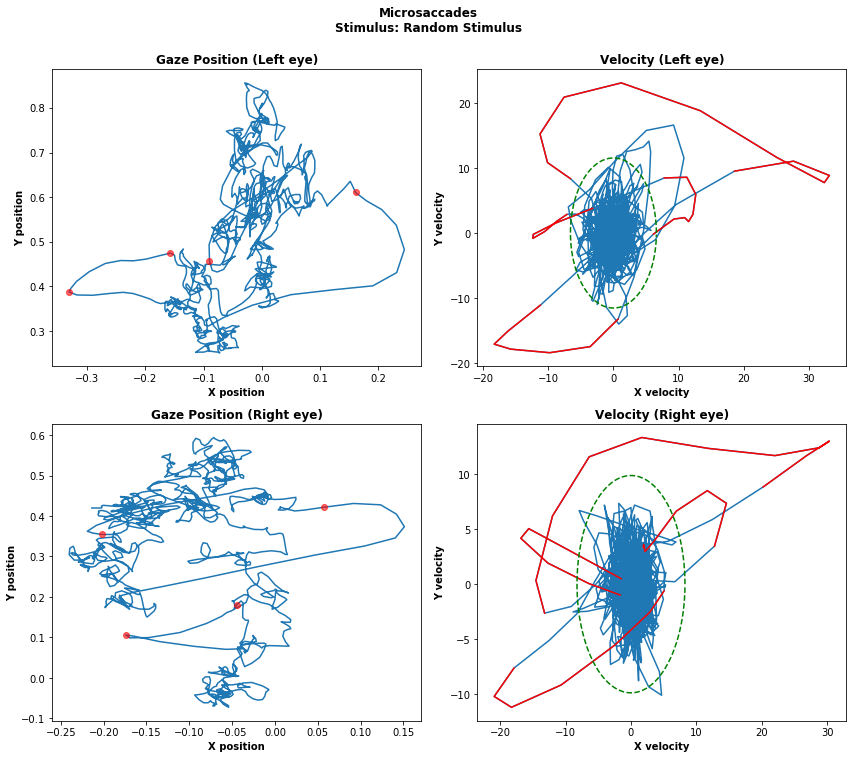

In [6]:
VFAC = 5.
MINDUR = 3.
SAMPLING = 500

# Apply running average
xls = smoothdata(xl)
xrs = smoothdata(xr)

# Detection of microsaccades
sacl = microsacc(xl,VFAC,3,500)
sacr = microsacc(xr,VFAC,3,500)

sac = binsac(sacl, sacr)

plotMicroSac(sacl=sacl, sacr=sacr, xls=xls, xrs=xrs, stimulusName = 'Random Stimulus', y = 1.05)

## Generation of surrogate data

,Timestamp,Leftx,Lefty,Rightx,Righty
0,0.0,0.06732,-0.22176,-0.25740,-0.86724
1,2.0,0.07524,-0.20196,-0.26136,-0.87120
2,4.0,0.08316,-0.20592,-0.25740,-0.86724
3,6.0,0.08316,-0.20988,-0.25740,-0.88704
4,8.0,0.07524,-0.20592,-0.25740,-0.85536


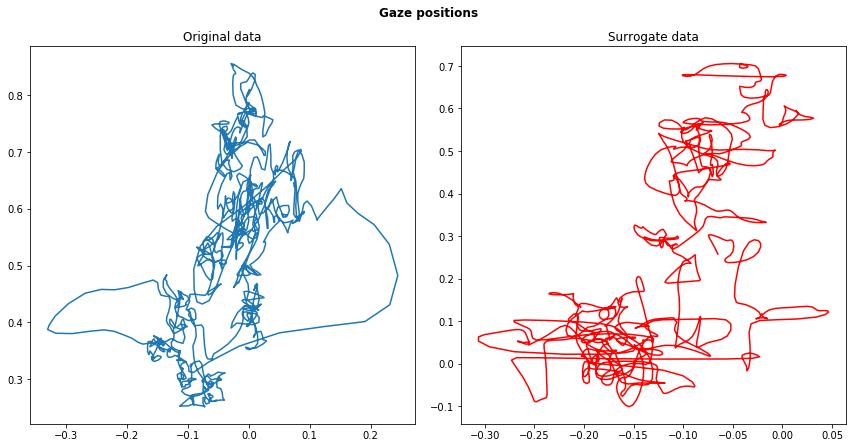

In [8]:
def ft(x):
    """Return simple Fourier transform surrogates.
    Returns phase randomized (FT) surrogates that preserve the power
    spectrum (or equivalently the linear correlations), but completely
    destroy the probability distribution.
    Parameters
    ----------
    x : array
        Real input array containg the time series.
    Returns
    -------
    y : array
        Surrogates with the same power spectrum as x.
    """
    y = np.fft.rfft(x)

    phi = 2 * np.pi * np.random.random(len(y))

    phi[0] = 0.0
    if len(x) % 2 == 0:
        phi[-1] = 0.0

    y = y * np.exp(1j * phi)
    return np.fft.irfft(y, n=len(x))

def aaft(x):
    """Return amplitude adjusted Fourier transform surrogates.
    Returns phase randomized, amplitude adjusted (AAFT) surrogates with
    crudely the same power spectrum and distribution as the original
    data (Theiler et al. 1992).  AAFT surrogates are used in testing
    the null hypothesis that the input series is correlated Gaussian
    noise transformed by a monotonic time-independent measuring
    function.
    Parameters
    ----------
    x : array
        1-D input array containg the time series.
    Returns
    -------
    y : array
        Surrogate series with (crudely) the same power spectrum and
        distribution.
    """
    # Generate uncorrelated Gaussian random numbers.
    y = np.random.normal(size=len(x))

    # Introduce correlations in the random numbers by rank ordering.
    y = np.sort(y)[np.argsort(np.argsort(x))]
    y = ft(y)

    return np.sort(x)[np.argsort(np.argsort(y))]

def iaaft(x, maxiter=1000, atol=1e-8, rtol=1e-10):
    """Return iterative amplitude adjusted Fourier transform surrogates.
    Returns phase randomized, amplitude adjusted (IAAFT) surrogates with
    the same power spectrum (to a very high accuracy) and distribution
    as the original data using an iterative scheme (Schreiber & Schmitz
    1996).
    Parameters
    ----------
    x : array
        1-D real input array of length N containing the time series.
    maxiter : int, optional (default = 1000)
        Maximum iterations to be performed while checking for
        convergence.  The scheme may converge before this number as
        well (see Notes).
    atol : float, optional (default = 1e-8)
        Absolute tolerance for checking convergence (see Notes).
    rtol : float, optional (default = 1e-10)
        Relative tolerance for checking convergence (see Notes).
    Returns
    -------
    y : array
        Surrogate series with (almost) the same power spectrum and
        distribution.
    i : int
        Number of iterations that have been performed.
    e : float
        Root-mean-square deviation (RMSD) between the absolute squares
        of the Fourier amplitudes of the surrogate series and that of
        the original series.
    Notes
    -----
    To check if the power spectrum has converged, we see if the absolute
    difference between the current (cerr) and previous (perr) RMSDs is
    within the limits set by the tolerance levels, i.e., if abs(cerr -
    perr) <= atol + rtol*perr.  This follows the convention used in
    the NumPy function numpy.allclose().
    Additionally, atol and rtol can be both set to zero in which
    case the iterations end only when the RMSD stops changing or when
    maxiter is reached.
    """
    # Calculate "true" Fourier amplitudes and sort the series.
    ampl = np.abs(np.fft.rfft(x))
    sort = np.sort(x)

    # Previous and current error.
    perr, cerr = (-1, 1)

    # Start with a random permutation.
    t = np.fft.rfft(np.random.permutation(x))

    for i in range(maxiter):
        # Match power spectrum.
        s = np.real(np.fft.irfft(ampl * t / np.abs(t), n=len(x)))

        # Match distribution by rank ordering.
        y = sort[np.argsort(np.argsort(s))]

        t = np.fft.rfft(y)
        cerr = np.sqrt(np.mean((ampl ** 2 - np.abs(t) ** 2) ** 2))

        # Check convergence.
        if abs(cerr - perr) <= atol + rtol * abs(perr):
            break
        else:
            perr = cerr

    # Normalize error w.r.t. mean of the "true" power spectrum.
    return y, i, cerr / np.mean(ampl ** 2)

# create surrogate data
# Import test data
d = pd.read_csv('eye_data.dat', sep = '\t', header = None,
                names = ['Timestamp','Leftx','Lefty','Rightx', 'Righty'])
display(d.head())


# Select epoch from trial, transform to dataframe
idx = list(np.arange(3000,4500)) #188219,189241
xl = np.asmatrix(d.iloc[idx,[1,2]])
xr = np.asmatrix(d.iloc[idx,[3,4]])

SAMPLING = 500
MINDUR = 3
VFAC = 5

xls = smoothdata(xl)

def surrogate(xls, SAMPLING=500):
    x0 = xls[0,:] # first row
    v = vecvel(xls,SAMPLING=SAMPLING)

    #vsx = AAFTsur(np.array([x[0,0] for x in v[:,0]]))/SAMPLING
    #vsy = AAFTsur(np.array([x[0,0] for x in v[:,1]]))/SAMPLING
    
    vsx = iaaft(np.array([x[0,0] for x in v[:,0]]))[0]/SAMPLING
    vsy = iaaft(np.array([x[0,0] for x in v[:,1]]))[0]/SAMPLING

    vsx[0] = vsx[0] + x0[:,0][0,0]
    vsy[0] = vsy[0] + x0[:,1][0,0]

    xs = np.cumsum(vsx)
    ys = np.cumsum(vsy)

    xsur = np.matrix(np.array([xs, ys], dtype = float).transpose())
    return xsur

x0 = xls[0,:] # first row
v = vecvel(xls,SAMPLING=SAMPLING)

#vsx = AAFTsur(np.array([x[0,0] for x in v[:,0]]))/SAMPLING
#vsy = AAFTsur(np.array([x[0,0] for x in v[:,1]]))/SAMPLING

vsx = iaaft(np.array([x[0,0] for x in v[:,0]]))[0]/SAMPLING
vsy = iaaft(np.array([x[0,0] for x in v[:,1]]))[0]/SAMPLING

vsx[0] = vsx[0] + x0[:,0][0,0]
vsy[0] = vsy[0] + x0[:,1][0,0]

xs = np.cumsum(vsx)
ys = np.cumsum(vsy)

xsur = np.matrix(np.array([xs, ys], dtype = float).transpose())

# Plot original data and surrogate data
fig, ax = plt.subplots(1,2, figsize = (12,6))
plt.suptitle('Gaze positions', fontweight = 'bold', y = 1.03)
ax[0].plot(xls[:,0],xls[:,1])
ax[0].set_title('Original data')
ax[1].plot(xsur[:,0],xsur[:,1], color = 'red')
ax[1].set_title('Surrogate data')
plt.tight_layout()
plt.show()

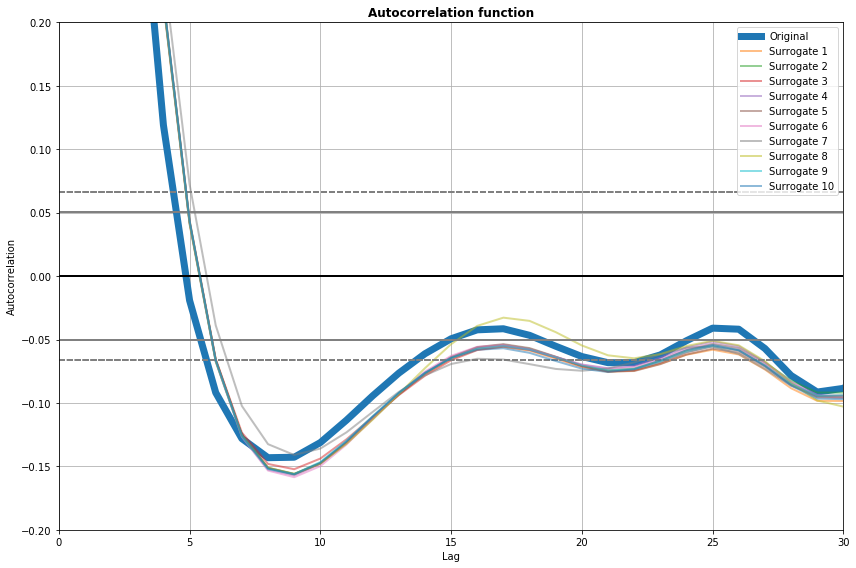

In [9]:
# Plot acf of original trajectory and surrogate tracetory
vls = vecvel(xls)
plt.figure(figsize = (12,8))
pd.tools.plotting.autocorrelation_plot(np.array([x[0,0] for x in vls[:,0]]), label = 'Original', linewidth=7.0)
plt.ylim([-0.2,0.2])
plt.xlim([0,30])
for s in range(10):
    xlsur = surrogate(xls)
    vlsur = vecvel(xlsur,TYPE=2)
    pd.tools.plotting.autocorrelation_plot(np.array([x[0,0] for x in vlsur[:,0]]),
                                           label = 'Surrogate {}'.format(s+1), alpha = 0.5, linewidth = 2)
plt.title("Autocorrelation function", fontweight = 'bold')
plt.tight_layout()
plt.show()

## Surrogate Analysis

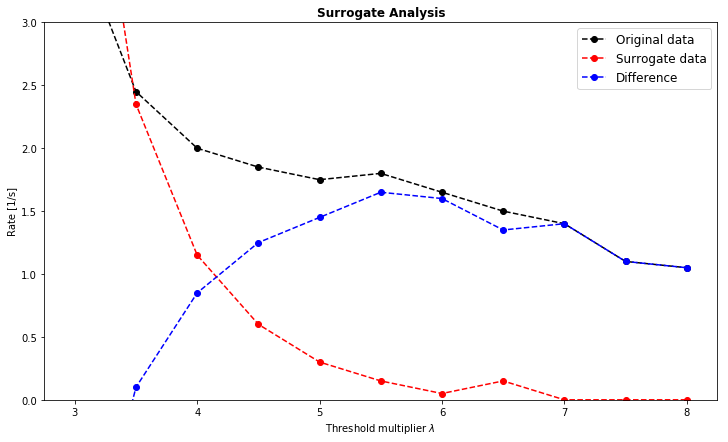

In [10]:
SAMPLING = 500

# Surrogate analysis for different threshold
vfac = np.arange(3,8.5,0.5)
num = len(vfac)
mstab = np.matrix(np.zeros((11,3),), dtype = float)

d = pd.read_csv('eye_data.dat', sep = '\t', header = None,
                names = ['Timestamp','Leftx','Lefty','Rightx', 'Righty'])
# select epoch, transform to matrix
xl = np.asmatrix(d.iloc[:,[1,2]])
xr = np.asmatrix(d.iloc[:,[3,4]])
dur = xr.shape[0]/SAMPLING

for i in np.arange(num):
    # detect microsaccades
    msl = microsacc(xl,VFAC=vfac[i],MINDUR=3,SAMPLING=500)
    msr = microsacc(xr,VFAC=vfac[i],MINDUR=3,SAMPLING=500)
    sac = binsac(msl,msr)
    
    sac = binsac(msl,msr)
    N = sac[0][0]/dur
    # computation of surrogate data
    xsl = surrogate(xl, SAMPLING = 500)
    xsr = surrogate(xr, SAMPLING = 500)
    msl = microsacc(xsl,VFAC=vfac[i],MINDUR=3,SAMPLING=500)
    msr = microsacc(xsr,VFAC=vfac[i],MINDUR=3,SAMPLING=500)
    sac = binsac(msl,msr)
    Nsur = sac[0][0]/dur
    mstab[i,0] = vfac[i]
    mstab[i,1:3] = mstab[i,1:3] + np.array([N,Nsur])

plt.figure(figsize = (10,6))
plt.title('Surrogate Analysis', fontweight = 'bold')
plt.plot(mstab[:,0],mstab[:,1], linestyle='--', marker='o', label = 'Original data', color = 'black')
plt.plot(mstab[:,0],mstab[:,2], linestyle='--', marker='o', label = 'Surrogate data', color = 'red')
plt.plot(mstab[:,0],mstab[:,1]-mstab[:,2], linestyle='--', marker='o', label = 'Difference', color = 'blue')
plt.legend(fontsize = 'large')
plt.tight_layout()
plt.xlabel(r'Threshold multiplier $\lambda$')
plt.ylabel("Rate [1/s]")
plt.ylim(0,3)
plt.show()